# Orange brix Analysis

## Import thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from enum import Enum
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import pickle

import os

In [2]:
plt.style.use("fivethirtyeight")

## Các cài đặt khác

In [3]:
# Biến GENERATE_PLOTS dùng để bật tắt việc vẽ đồ thị.
# Tắt đi để tăng tốc chạy test. (không chạy những hàm plot)
GENERATE_PLOTS: bool = True

# Biến boolean để bật tắt việc traing model khi ấn "Run all"
TRAIN_MODEL_1: bool = False
TRAIN_MODEL_2: bool = False
TRAIN_MODEL_3: bool = False
TRAIN_MODEL_4: bool = False
TRAIN_MODEL_5: bool = False

## Tạo các Class

### Class Utilities

In [4]:
# Class Utilities có các phương thức tiện ích.
# Các class khác muốn sử dụng các tiện ích này thì
# chỉ cần kế thừa class Utilities này.

class Utilities:
    def __init__(self):
        pass

    def get_categorical_numeric_cols(self, dataframe: pd.DataFrame):
        if len(dataframe) == 0:
            raise Exception("No records found!")

        numeric_cols = []
        categorical_cols = []

        for col in dataframe.columns:
            if isinstance(dataframe[col][0], bool) or not isinstance(
                dataframe[col][0], (int, float, np.int8, np.int16, np.int32, np.int64, np.float16, np.float32, np.float64)
            ):
                categorical_cols.append(col)
            else:
                numeric_cols.append(col)

        return (categorical_cols, numeric_cols)

### Enum ScalerType

In [5]:
# Khai báo Enum của các loại Scaler data từ submoule
# preprocessing của thư viện sklearn.

from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    RobustScaler,
    StandardScaler,
)


class ScalerType(Enum):
    Raw_ = None
    MaxAbsScaler_ = MaxAbsScaler
    MinMaxScaler_ = MinMaxScaler
    Normalizer_ = Normalizer
    RobustScaler_ = RobustScaler
    StandardScaler_ = StandardScaler

### Class Dataset

In [6]:
# Class Dataset chứa 1 dataframe và các metadata của
# dataframe này (tên, loại scaler, tên cột biến định
# danh, tên cột biến định lượng)


class Dataset(Utilities):
    def __init__(
        self,
        name: str,
        dataframe: pd.DataFrame,
        scaler_type: ScalerType = ScalerType.Raw_,
    ):
        self.name: str = name
        self.dataframe: pd.DataFrame = dataframe
        self.categorical_cols: list[str] = []
        self.numeric_cols: list[str] = []
        self.scaler_type: ScalerType = scaler_type

        self.categorical_cols, self.numeric_cols = self.get_categorical_numeric_cols(
            self.dataframe
        )

    def get_name(self) -> str:
        return self.name

    def get_dataframe(self) -> pd.DataFrame:
        return self.dataframe

    def detect_categorical_numeric_cols(self):
        if len(self.dataframe) == 0:
            raise Exception("No records found!")

        self.numeric_cols = []
        self.categorical_cols = []

        for col in self.dataframe.columns:
            try:
                float(self.dataframe[col][0])
                self.numeric_cols.append(col)
            except:
                self.categorical_cols.append(col)

    def get_numeric_cols(self) -> list[str]:
        return self.numeric_cols

    def get_numeric_dataframe(self) -> pd.DataFrame:
        return self.dataframe[self.numeric_cols]

    def get_categorical_dataframe(self) -> pd.DataFrame:
        return self.dataframe[self.categorical_cols]

    def get_scaler_type(self) -> ScalerType:
        return self.scaler_type

    def concat_dataframe(self, additional_dataframe: pd.DataFrame):
        if len(additional_dataframe) == len(self.dataframe):
            self.dataframe = pd.concat([self.dataframe, additional_dataframe], axis=1)
            self.detect_categorical_numeric_cols()

    def get_one_hot_vectorized_dataset(
        self, categorical_col: str, print_name: bool = True
    ):
        if categorical_col in self.categorical_cols:
            dummies_dataframe = pd.get_dummies(self.dataframe[categorical_col])
            dummies_dataframe = pd.concat([dummies_dataframe, self.dataframe], axis=1)
            new_dataset_name = self.name + "_ohv_" + categorical_col
            if print_name:
                print(new_dataset_name)
            return Dataset(
                name=new_dataset_name,
                dataframe=dummies_dataframe,
                scaler_type=self.scaler_type,
            )
        elif categorical_col in self.numeric_cols:
            print("Records for input column name are not categorical!")
        else:
            print("Input column name does not exists!")

### Enum ModelType

In [7]:
# ModelType là Enum khai báo các loại model từ thư viện
# sklearn và một số mô hình từ nguồn khác (xgb, lightgbm).
# Mỗi loại model được khai báo một bộ tham số đi kèm.


class ModelType(Enum):
    LINEAR_REGRESSION: dict = {}
    SVR: dict = {
        "kernel": "rbf",  # | linear, poly, rbf
        "degree": 3,
        "gamma": "scale",
        "coef0": 0,
        "tol": 1e-3,
        "C": 1.0,  # 0.1 - 2 step 0.1
        "epsilon": 0.1,
    }
    DECISION_TREE: dict = {
        "criterion": "squared_error",
        "splitter": "best",
        "max_depth": None,  # 1 - number of feature
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "min_weight_fraction_leaf": 0.0,
        "max_features": None,  # int 2->5 {“sqrt”, “log2”}, default=None
        "random_state": 42,
        "max_leaf_nodes": None,
        "min_impurity_decrease": 0,
    }
    RANDOM_FOREST: dict = {
        "n_estimators": 100,  # int 100-1000 (step 100)
        "criterion": "squared_error",
        "max_depth": None,  # 1 - number of feature
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "min_weight_fraction_leaf": 0.0,
        "max_features": 1.0,  # int 2->5 {“sqrt”, “log2”}, default=None
        "max_leaf_nodes": None,
        "min_impurity_decrease": 0.0,
    }
    LIGHT_GBM: dict = {
        "boosting_type": "gbdt",
        "num_leaves": 31,
        "max_depth": -1,
        "learning_rate": 0.1,
        "n_estimator": 100,  # int 100-1000 (step 100)
        "verbosity": -1,
    }
    XGB: dict = {
        "objective": "reg:linear",
        "n_estimators": 10,  # int 100-1000 (step 100)
        "seed": 123,
        "verbosity": 0,
    }

### Class Result

In [8]:
# Class Result dùng để chứa kết quả huấn luyện và các
# thông tin liên quan của một bộ (mô hình + dữ liệu).

# Một kết quả gồm:
# - Tên bộ dữ liệu
# - Tên của bộ tham số pretrained
# - Loại mô hình
# - Loại scaler
# - Kết quả r^2
# - Kết quả mse
# - Các tham số pretrained


class Result:
    def __init__(
        self,
        dataset_name: str,
        pretrained_model_features: str,
        model_type: ModelType,
        scaler_type: str,
        r2: float,
        mse: float,
        params: str,
    ):
        self.result = [
            dataset_name,
            pretrained_model_features,
            model_type,
            scaler_type,
            r2,
            mse,
            params,
        ]

    def get_result(self):
        return self.result

### Class ResultFrame

In [9]:
# Class ResultFrame chứa bảng chứa tất cả kết quả của
# một vòng huấn luyện mô hình.
# ResultFrame chứa một pd.DataFrame nên có thể hỗ trợ
# việc sắp xếp, lọc, xuất kết quả...


class ResultFrame:
    def __init__(self):
        self.result_frame: pd.DataFrame = pd.DataFrame()
        self.count = 0

        self.start_up()

    def start_up(self):
        self.result_frame["dataset_name"] = []
        self.result_frame["pretrained_model_features"] = []
        self.result_frame["model_type"] = []
        self.result_frame["scaler_type"] = []
        self.result_frame["r2"] = []
        self.result_frame["mse"] = []
        self.result_frame["params"] = []

    def add_result(self, new_result: Result):
        self.result_frame.loc[self.count] = new_result.result
        self.count += 1

    def display_result(self, display_rows: int = 30):
        self.result_frame.sort_values(["r2", "mse"], ascending=False, inplace=True)
        if display_rows < 0:
            display_rows = 30
        display(self.result_frame.head(display_rows))

    def save_result(self, filename=None, overwrite=False):
        if self.result_frame.shape[0] == 0:
            print("Result has no records!")
        elif not filename:
            filename = (
                self.result_frame["dataset_name"][0]
                + "_"
                + self.result_frame["pretrained_model_features"][0]
                + ".xlsx"
            )
            self.result_frame.to_excel(filename)
        else:
            file_exists = os.path.isfile(os.path.join(os.getcwd(), filename))
            if file_exists and not overwrite:
                print("Error: CANNOT SAVE FILE.")
                print("A file with the same name already exists.")
                print(
                    "Set overwrite to True to overwrite existed file or change file name!"
                )
            else:
                self.result_frame.to_excel(filename)

### Class Model (là class quan trọng nhất trong notebook này)

In [10]:
# Class Model dùng để tiền xử lý dữ liệu, huấn luyện và
# đánh giá mô hình với bộ dữ liệu đã cho ở đầu vào.

# Tham số đầu vào:
# - dataset_name: tên của Dataset
# - pretrained_model_features: tên của bộ tham số pretrained
# - model_type: loại Model
# - x_cols: một list chứa tên các cột sử dụng làm biến giải thích
# - y_cols: một list chứa tên các cột biến phản hồi
# - dataset: dataset mình muốn xử lý (dataset này có thể có
#       các cột không liên quan, các dữ liệu cho X và Y sẽ được
#       trích xuất tự động và các dữ liệu không liên quan sẽ bị loại bỏ)
# - scaler_type: loại scaler cho dữ liệu


class Model(Utilities):
    def __init__(
        self,
        dataset_name: str,
        pretrained_model_features: list[str],
        model_type: ModelType,
        x_cols: list[str],
        y_cols: list[str],
        dataset: Dataset,
        scaler_type: ScalerType = ScalerType.Raw_,
    ):

        if len(x_cols) == 0 or len(y_cols) == 0:
            raise Exception("Data columns are not specified!")

        self.dataset_name: str = dataset_name
        self.model_type: ModelType = model_type
        self.pretrained_model_features = str(pretrained_model_features)
        self.scaler_type: ScalerType = scaler_type
        self.scaler = self.get_scaler(self.scaler_type)  # could be None
        self.params = self.model_type.value
        self.x_dataset: Dataset = None
        self.y_dataset: Dataset = None
        self.inner_model = None
        self.r2 = None
        self.mse = None

        self.preprocess_data(x_cols, y_cols, dataset)

    # Extract data from x_cols and y_cols
    # Redetect categorical and numeric columns
    def preprocess_data(self, x_cols: list[str], y_cols: list[str], dataset: Dataset):
        x_dataset_new_name = dataset.get_name() + "_x"
        y_dataset_new_name = dataset.get_name() + "_y"
        scaler_type = dataset.get_scaler_type()
        self.x_dataset = Dataset(
            name=x_dataset_new_name,
            dataframe=dataset.get_dataframe()[x_cols],
            scaler_type=scaler_type,
        )
        self.y_dataset = Dataset(
            name=y_dataset_new_name,
            dataframe=dataset.get_dataframe()[y_cols],
            scaler_type=scaler_type,
        )

        self.process_x_dataset()

    # arrange [numeric_cols, categorical_cols]
    def process_x_dataset(self):
        new_name = self.x_dataset.get_name()
        numeric_dataframe = self.x_dataset.get_numeric_dataframe()
        categorical_dataframe = self.x_dataset.get_categorical_dataframe()
        scaler_type = self.x_dataset.get_scaler_type()
        self.x_dataset = Dataset(
            name=new_name,
            dataframe=pd.concat([numeric_dataframe, categorical_dataframe], axis=1),
            scaler_type=scaler_type,
        )

    def get_x_list_index_numeric_cols(self):
        return list(range(len(self.x_dataset.get_numeric_cols())))

    def fit_scaler_and_scale_dataframe(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.scaler is not None:
            list_index = self.get_x_list_index_numeric_cols()
            X_numeric = X[:, list_index]
            X_categorical = X[:, len(list_index) :].astype(int)
            self.scaler.fit(X_numeric)
            transformed_X = self.scaler.transform(X_numeric)
            transformed_X = np.concatenate([transformed_X, X_categorical], axis=1)
        else:
            transformed_X = X

        return transformed_X

    def get_x_dataframe(self):
        return self.x_dataset.get_dataframe()

    def get_y_dataframe(self):
        return self.y_dataset.get_dataframe()

    def get_scaler(self, scaler_type: ScalerType):
        if scaler_type != ScalerType.Raw_:
            return scaler_type.value()

    def display_progress(self):
        print(
            f"Training | ModelType: {self.model_type} | Datasetname: {self.dataset_name} | ScalerType: {self.scaler_type} | Params: {self.params}"
        )
        print(f"R2: {self.r2} | MSE: {self.mse}")

    def fit(self, X=None, Y=None):
        if X is None:
            X = np.array(self.x_dataset.get_dataframe())
            Y = np.array(self.y_dataset.get_dataframe())

        model_family = self.model_type.__str__().split(".")[-1]

        Y = np.squeeze(Y)

        # need to scale
        transformed_X = self.fit_scaler_and_scale_dataframe(X)

        if model_family == "SVR":
            self.model = SVR(**(self.params)).fit(transformed_X, Y)
        elif model_family == "LINEAR_REGRESSION":
            self.model = LinearRegression(**(self.params)).fit(transformed_X, Y)
        elif model_family == "DECISION_TREE":
            self.model = DecisionTreeRegressor(**(self.params)).fit(transformed_X, Y)
        elif model_family == "RANDOM_FOREST":
            self.model = RandomForestRegressor(**(self.params)).fit(transformed_X, Y)
        elif model_family == "LIGHT_GBM":
            self.model = LGBMRegressor(**(self.params)).fit(transformed_X, Y)
        elif model_family == "XGB":
            self.model = XGBRegressor(**(self.params)).fit(transformed_X, Y)
        else:
            raise ValueError("Unknown model family!")

    def predict(self, X):
        if self.scaler is not None:
            list_index = self.get_x_list_index_numeric_cols()
            X_numeric = X[:, list_index]
            X_categorical = X[:, len(list_index) :].astype(int)
            transformed_X = self.scaler.transform(X_numeric)
            transformed_X = np.concatenate([transformed_X, X_categorical], axis=1)
        else:
            transformed_X = X
        return self.model.predict(transformed_X)

    def evaluate(self, X=None, Y=None, method="LOOCV"):
        if X is None:
            X = np.array(self.x_dataset.get_dataframe())
            Y = np.array(self.y_dataset.get_dataframe())
        if method == "LOOCV":
            preds = [0] * len(Y)
            total = len(Y)
            kf = KFold(n_splits=total)
            kf.get_n_splits(Y)

        with tqdm(total=total) as pbar:
            for i, (train_index, valid_index) in enumerate(kf.split(X, Y)):
                X_train = X[train_index]
                Y_train = Y[train_index]
                X_valid = X[valid_index]
                Y_valid = Y[valid_index]

                self.fit(X_train, Y_train)

                Y_valid_pred = self.predict(X_valid)
                for j in range(len(valid_index)):
                    index = valid_index[j]
                    value = Y_valid_pred[j]
                    preds[index] = value
                pbar.update(1)

        self.r2 = r2_score(Y, preds)
        self.mse = mean_squared_error(Y, preds)

        self.display_progress()

        # Compile result
        return Result(
            dataset_name=self.dataset_name,
            pretrained_model_features=self.pretrained_model_features,
            model_type=self.model_type.name,
            scaler_type=self.scaler_type.name,
            r2=self.r2,
            mse=self.mse,
            params=self.params,
        )

    def save(self, filename: str):
        pickle.dump(self.inner_model, open(filename, "wb"))

    def load(self, filename: str):
        pickle.dump(self.inner_model, open(filename, "wb"))

    def set_params(self, params: dict):
        self.params = params

### Các biến global trong notebook

In [11]:
# list_dataset: một dictionary chứa toàn bộ dataset của
# notebook
list_dataset: dict[str, Dataset] = dict()

# result_frame: dùng để lưu các kết quả của việc huấn luyện
# mô hình.
result_frame: ResultFrame = ResultFrame()

# hyper_params: dùng để lưu các tham số cho việc fine-tuning
# mô hình.
hyper_params = {
    "SVR": {"kernel": ["rbf", "linear", "poly"], "C": np.arange(0.1, 2, 0.1)},
    "RANDOM_FOREST": {
        "n_estimators": np.arange(100, 1100, 100),
        "max_depth": [None, 5, 10, 15, 20],
        "max_features": [10, 50, 100, 150, 200, "sqrt", "log2", None],
    },
    "LIGHT_GBM": {
        "max_depth": [-1],  # , 5, 10, 15, 20],
        "learning_rate": [0.01],  # , 0.05, 0.1],
        "min_child_samples": [20],
        "n_estimators": np.arange(800, 1000, 100),
        # "subsample" : [1.0, 0.8, 0.6, 0.5],
        #  "colsample_bytree" : [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        #   "reg_alpha": [0, 0.01, 0.05, 0.1, 0.2],
        # "reg_lambda": [0, 0.01, 0.05, 0.1, 0.2],
    },
}

## Các hàm để vẽ đồ thị, biểu đồ

### plot_numeric_along_dataframe

In [12]:
# Hàm này vẽ line plot cho tất cả các cột dữ liệu
# định lượng.
# Dữ liệu chạy theo thứ tự lúc import.
# Hàm này để có cái nhìn ban đầu về bộ dữ liệu.

# Hàm này nhận 4 tham số
# - dataset: dataset đầu vào
# - nrow_subplot: số hàng của subplot
# - ncol_subplot: số cột của subplot
# - figsize: để tùy chỉnh kích thước của hình vẽ


def plot_numeric_along_dataframe(
    dataset: Dataset,
    nrow_subplot: int,
    ncol_subplot: int,
    figsize: tuple[int, int],
):
    numeric_df = dataset.get_numeric_dataframe()
    x = np.arange(len(numeric_df))
    figs, axes = plt.subplots(nrow_subplot, ncol_subplot, figsize=figsize)
    for i in range(nrow_subplot):
        for j in range(ncol_subplot):
            ax = axes[i][j]
            index = i * ncol_subplot + j
            ax.plot(x, numeric_df.iloc[:, index])
            ax.set_title(f"{numeric_df.columns[index]} along dataframe", size=15)
            ax.xaxis.set_tick_params(labelsize=12)
            ax.xaxis.set_ticks(np.arange(0, len(numeric_df), 10))
            ax.yaxis.set_tick_params(labelsize=12)

### plot_hist_kde_box_all_columns

In [13]:
# Hàm này vẽ các 3 plot cho mỗi biến định lượng của dữ liệu
# 3 đồ thị 
# - Đồ thị histogram
# - Đồ thị KDE (kerner density estimation)
# - Đồ thị Boxplot

def plot_hist_kde_box_all_columns(dataset: Dataset):

    number_of_numeric_col = len(dataset.numeric_cols)
    figs, axes = plt.subplots(
        number_of_numeric_col, 3, figsize=(30, number_of_numeric_col * 10)
    )

    numeric_dataframe = dataset.get_dataframe()[dataset.numeric_cols]

    for i in range(number_of_numeric_col):
        axes[i][0].set_title(f"{numeric_dataframe.columns[i]} histogram", size=20)
        axes[i][0].yaxis.set_tick_params(labelsize=15)
        axes[i][0].xaxis.set_tick_params(labelsize=15)
        sns.histplot(ax=axes[i][0], data=numeric_dataframe.iloc[:, i])

        axes[i][1].set_title(f"{numeric_dataframe.columns[i]} KDE", size=20)
        axes[i][1].xaxis.set_tick_params(labelsize=15)
        axes[i][1].yaxis.set_tick_params(labelsize=15)
        sns.kdeplot(ax=axes[i][1], data=numeric_dataframe.iloc[:, i])

        axes[i][2].set_title(f"{numeric_dataframe.columns[i]} Boxplot", size=20)
        axes[i][2].xaxis.set_tick_params(labelsize=15)
        axes[i][2].yaxis.set_tick_params(labelsize=15)
        sns.boxplot(ax=axes[i][2], data=numeric_dataframe.iloc[:, i])

### plot_all_columns_group_by_a_categorical_col

In [14]:
# Hàm plot các cột dữ liệu định lượng được phân chia thành
# các loại từ 01 cột định danh cho trước.

def plot_all_columns_group_by_a_categorical_col(dataset: Dataset, categorical_col: str):

    dataframe = dataset.get_dataframe()
    numeric_dataframe = dataframe[dataset.numeric_cols]
    number_of_numeric_col = len(dataset.numeric_cols)
    figs, axes = plt.subplots(
        number_of_numeric_col, 2, figsize=(20, number_of_numeric_col * 10)
    )
    groups = dataframe[categorical_col].unique()

    for i in range(number_of_numeric_col):
        axes[i][0].set_title(f"{numeric_dataframe.columns[i]} KDE", size=20)
        axes[i][0].xaxis.set_tick_params(labelsize=15)
        axes[i][0].yaxis.set_tick_params(labelsize=15)
        for group in groups:
            sns.kdeplot(
                ax=axes[i][0],
                data=numeric_dataframe[dataframe[categorical_col] == group].iloc[:, i],
                label=f"Type {group}",
            )
        axes[i][0].legend()

        axes[i][1].set_title(f"{numeric_dataframe.columns[i]} Boxplot", size=20)
        axes[i][1].xaxis.set_tick_params(labelsize=15)
        axes[i][1].yaxis.set_tick_params(labelsize=15)
        sns.boxplot(
            ax=axes[i][1],
            hue="type",
            y=numeric_dataframe.columns[i],
            data=dataframe,
        )

### divide_dataframe_with_categorical_col

In [15]:
# Chia dataframe thành các dataframe theo nhóm của
# một biến định danh cho trước.

def divide_dataframe_with_categorical_col(
    dataset: Dataset, categorical_col: str
) -> dict[str, pd.DataFrame]:
    dataframe = dataset.get_dataframe()
    groups = dataframe[categorical_col].unique()

    result = {}
    for group in groups:
        result[group] = dataframe[dataframe[categorical_col] == group]

    return result

### calculate_p_values_between_partitions

In [16]:
# Tính p_value của các cột trong bảng, chia theo
# một biến giải thích định danh cho trước.

def calculate_p_values_between_partitions(dataframes, columns_to_compare):
    p_values = {}
    for key1, df1 in dataframes.items():
        for key2, df2 in dataframes.items():
            if key1 != key2:
                for col in columns_to_compare:
                    if col in df1 and col in df2:
                        t_stat, p_val = stats.ttest_ind(df1[col], df2[col])
                        p_values[f"{col}_{key1}-{col}_{key2}"] = p_val
    return p_values

## Bắt đầu phân tích

### Import dữ liệu

In [17]:
raw_df = pd.read_excel("orange_data.xlsx", sheet_name=0)

In [18]:
raw_df.head(10)

,Name,p,C NaOH,Khối lượng(g),Đường kính ngang(mm),Đường kính dọc(mm),Độ đường (Brix %),TA (%),Brix:TA,BrmTA
0,A1,1.90,0.4000,255,257,262,10.9,4.867141,2.239508,6.032859
1,A2,1.20,0.4000,325,288,278,9.8,3.073984,3.188045,6.726016
2,A3,2.30,0.4000,185,235,237,11.0,5.891803,1.867001,5.108197
3,A4,1.40,0.4128,203,245,245,9.0,3.701077,2.431725,5.298923
4,A5,1.20,0.4000,229,253,249,10.9,3.073984,3.545887,7.826016
5,A7,1.30,0.4128,357,305,290,10.7,3.436714,3.113439,7.263286
6,A8,2.00,0.4000,309,275,285,11.2,5.123307,2.186088,6.076693
7,A9,1.90,0.4128,321,285,280,9.2,5.022890,1.831615,4.177110
8,A10,1.45,0.4082,245,255,259,9.5,3.790542,2.506238,5.709458
9,A11,2.00,0.4128,275,267,270,10.5,5.287252,1.985909,5.212748


In [47]:
raw_df.isnull().sum()

Name                    0
p                       0
C NaOH                  0
Khối lượng(g)           0
Đường kính ngang(mm)    0
Đường kính dọc(mm)      0
Độ đường (Brix %)       0
TA (%)                  0
Brix:TA                 0
BrmTA                   0
dtype: int64

#### Nhận định
- Không có dữ liệu null.

### Chuẩn hóa tên cột

In [19]:
raw_df.columns

Index(['Name', 'p', 'C NaOH', 'Khối lượng(g)', 'Đường kính ngang(mm)',
       'Đường kính dọc(mm)', 'Độ đường (Brix %)', 'TA (%)', 'Brix:TA',
       'BrmTA'],
      dtype='object')

In [20]:
new_column_names = {
    "Name": "name",
    "p": "v_naoh",
    "C NaOH": "c_naoh",
    "Khối lượng(g)": "mass",
    "Đường kính ngang(mm)": "h_diameter",
    "Đường kính dọc(mm)": "v_diameter",
    "Độ đường (Brix %)": "brix",
    "TA (%)": "ta",
    "Brix:TA": "brix_ta",
    "BrmTA": "brm_ta",
}

std_col_name_dataframe = raw_df.rename(columns=new_column_names)

In [21]:
# pd.set_option('display.max_rows', 20)
pd.set_option('display.max_rows', None)
std_col_name_dataframe

,name,v_naoh,c_naoh,mass,h_diameter,v_diameter,brix,ta,brix_ta,brm_ta
0,A1,1.90,0.4000,255,257,262,10.90,4.867141,2.239508,6.032859
1,A2,1.20,0.4000,325,288,278,9.80,3.073984,3.188045,6.726016
2,A3,2.30,0.4000,185,235,237,11.00,5.891803,1.867001,5.108197
3,A4,1.40,0.4128,203,245,245,9.00,3.701077,2.431725,5.298923
4,A5,1.20,0.4000,229,253,249,10.90,3.073984,3.545887,7.826016
5,A7,1.30,0.4128,357,305,290,10.70,3.436714,3.113439,7.263286
6,A8,2.00,0.4000,309,275,285,11.20,5.123307,2.186088,6.076693
7,A9,1.90,0.4128,321,285,280,9.20,5.022890,1.831615,4.177110
8,A10,1.45,0.4082,245,255,259,9.50,3.790542,2.506238,5.709458
9,A11,2.00,0.4128,275,267,270,10.50,5.287252,1.985909,5.212748


#### Nhận định
- Dữ liệu gồm 81 bản ghi và 10 trường dữ liệu
- Cột "name" có nhãn ghi tiền tố A, B, C
=> Có thể dữ liệu được chia thành 3 nhóm A, B, C

### Khảo sát dữ liệu

In [22]:
std_col_name_dataframe.shape

(81, 10)

In [23]:
std_col_name_dataframe.describe()

,v_naoh,c_naoh,mass,h_diameter,v_diameter,brix,ta,brix_ta,brm_ta
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,1.477778,0.406857,222.197531,241.777778,241.358025,11.169259,3.849815,3.024935,7.319445
std,0.297069,0.007092,50.582215,23.652167,22.587225,1.362702,0.774895,0.786520,1.587514
min,0.800000,0.400000,126.000000,195.000000,197.000000,7.400000,2.057520,1.795715,4.076693
25%,1.300000,0.401600,179.000000,222.000000,223.000000,10.400000,3.370111,2.512846,6.148368
50%,1.400000,0.404800,228.000000,242.000000,242.000000,11.100000,3.701077,2.920633,7.332125
75%,1.600000,0.408200,255.000000,257.000000,255.000000,12.300000,4.229802,3.371688,8.199505
max,2.300000,0.423000,357.000000,305.000000,290.000000,14.000000,5.891803,6.609899,11.542480


#### Nhận định
- c_naoh có độ lệch chuẩn rất nhỏ, thể hiện rằng
dữ liệu này gần như không thay đổi trong cả bộ
dữ liệu

### Trực quan hóa dữ liệu

#### Lưu dữ liệu vào dictionary list_dataset
Tạo ra một Dataset để lưu dataframe "std_col_name_dataframe"

- Đặt tên là "orange_std_col_name" (orange stander colum names)
- dataframe: std_col_name_dataframe
- Kiểu scaler của dataframe này là ScalerType.Raw_ (chưa scale)

In [24]:
list_dataset["orange_std_col_name"] = Dataset(
    "orange_std_col_name", std_col_name_dataframe, ScalerType.Raw_
)

In [25]:
list_dataset["orange_std_col_name"].get_dataframe()

,name,v_naoh,c_naoh,mass,h_diameter,v_diameter,brix,ta,brix_ta,brm_ta
0,A1,1.90,0.4000,255,257,262,10.90,4.867141,2.239508,6.032859
1,A2,1.20,0.4000,325,288,278,9.80,3.073984,3.188045,6.726016
2,A3,2.30,0.4000,185,235,237,11.00,5.891803,1.867001,5.108197
3,A4,1.40,0.4128,203,245,245,9.00,3.701077,2.431725,5.298923
4,A5,1.20,0.4000,229,253,249,10.90,3.073984,3.545887,7.826016
5,A7,1.30,0.4128,357,305,290,10.70,3.436714,3.113439,7.263286
6,A8,2.00,0.4000,309,275,285,11.20,5.123307,2.186088,6.076693
7,A9,1.90,0.4128,321,285,280,9.20,5.022890,1.831615,4.177110
8,A10,1.45,0.4082,245,255,259,9.50,3.790542,2.506238,5.709458
9,A11,2.00,0.4128,275,267,270,10.50,5.287252,1.985909,5.212748


#### Plot dữ liệu cho các biến định lượng 

In [26]:
list_dataset["orange_std_col_name"].get_numeric_cols()

['v_naoh',
 'c_naoh',
 'mass',
 'h_diameter',
 'v_diameter',
 'brix',
 'ta',
 'brix_ta',
 'brm_ta']

Ta thấy có 9 cột nên ta có thể vẽ một ma trận
biểu đồ 3x3.

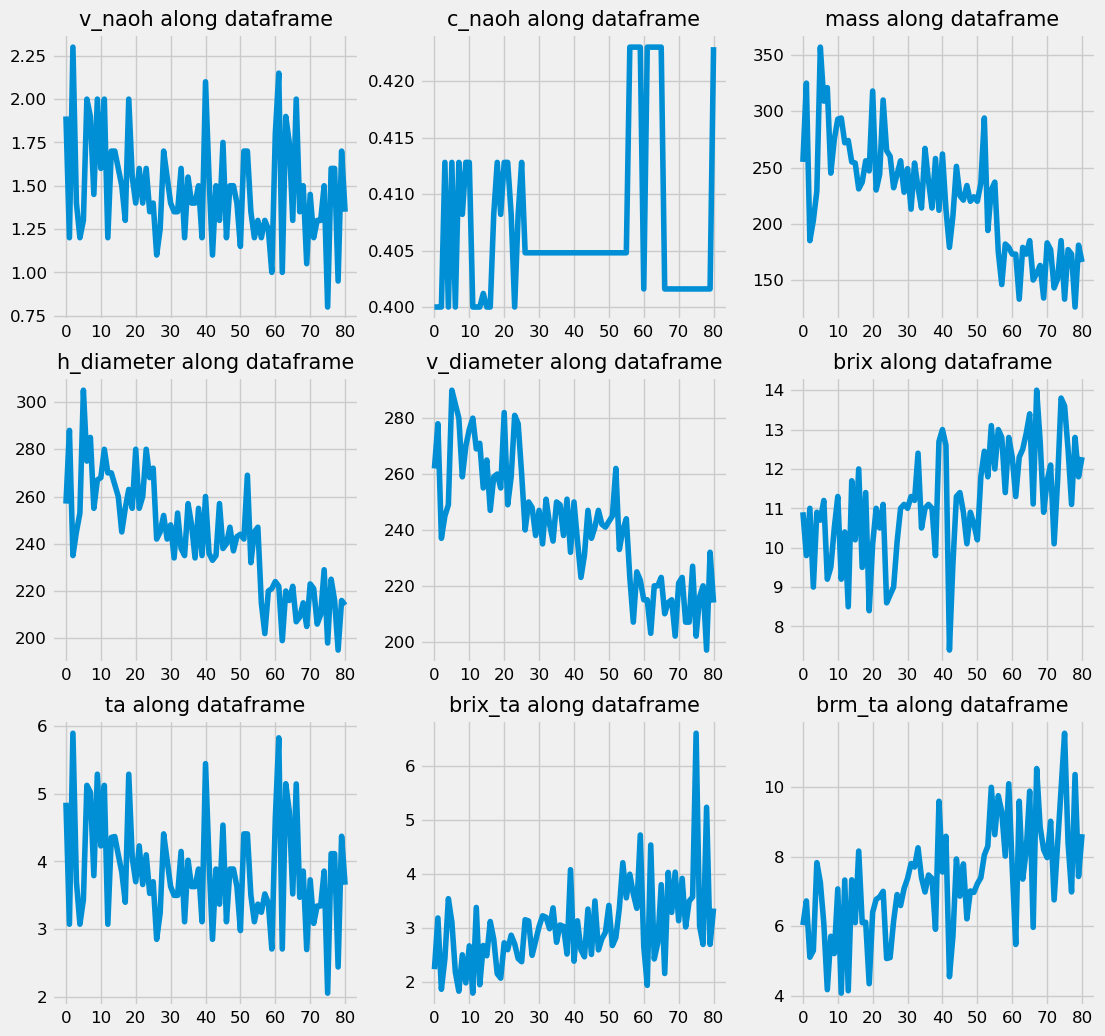

In [27]:
# Đặt biến boolean để activate
if GENERATE_PLOTS: 
    plot_numeric_along_dataframe(list_dataset["orange_std_col_name"], 3, 3, (12, 12))

#### Nhận định
- Đồ thị đường của dữ liệu "h_diameter", "v_diameter", "brix", "brm_ta"
chia thành 3 mức khá rõ ràng.
- Đồ thị đường của dữ liệu "mass" chỉ thấy chia thành 2 mức.
- Đồ thị đường của dữ liệu khác thì chưa thấy có pattern gì rõ ràng.

#### Plot histogram, KDE và boxplot của các biến định lượng

C:\Users\lyduc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lyduc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lyduc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lyduc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

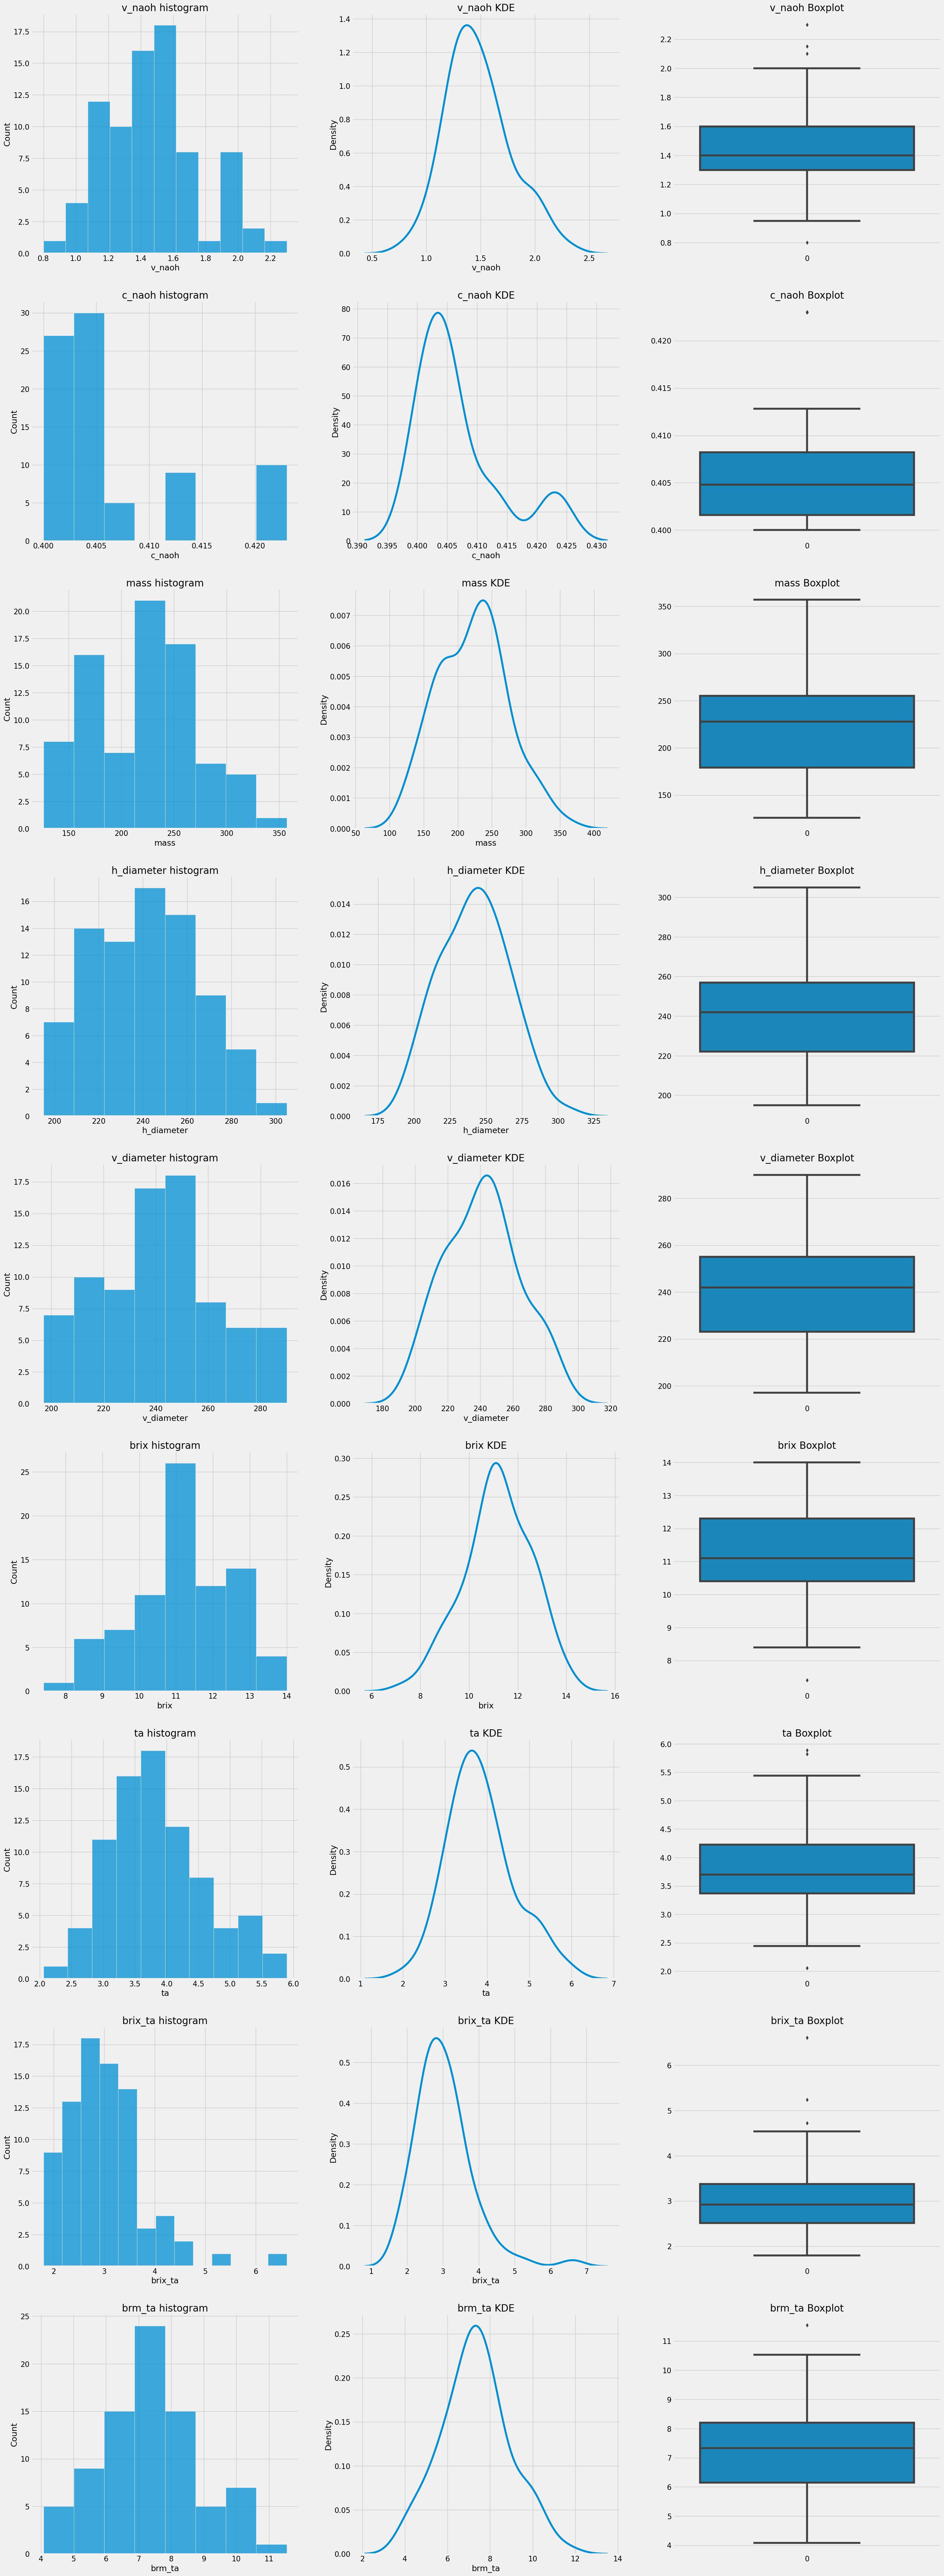

In [28]:
if GENERATE_PLOTS:
    plot_hist_kde_box_all_columns(list_dataset["orange_std_col_name"])

In [31]:
# kurtosis of normal == 0.0
list_dataset["orange_std_col_name"].get_dataframe().kurtosis(numeric_only=True)

v_naoh        0.108709
c_naoh        0.760385
mass         -0.312707
h_diameter   -0.416495
v_diameter   -0.641989
brix         -0.109207
ta            0.191656
brix_ta       4.801462
brm_ta       -0.047842
dtype: float64

#### Nhận định
- Các dữ liệu có Kutorsis nhỏ hơn 0 (normal distribution) cho thấy dữ liệu tập trung nhiều
quanh giá trị trung tâm.
- Do đó dữ liệu có xu hướng có ít ngoại lệ (outliers).
- Dữ liệu "brix_ta" có Kutorsis cho thấy dữ liệu phân bố nhiều về hai cực. Do đó khả năng cao
sẽ có nhiều giá trị ngoại lệ (outliers).

### Phân loại dữ liệu

Ta thấy nhãn A, B, C của dữ liệu có ý nghĩa phân nhóm.
Ta sẽ kiểm định xem dữ liệu này có thực sự chia làm 3 nhóm được không.

In [35]:
print(list_dataset["orange_std_col_name"].get_dataframe()["name"].to_list())

['A1', 'A2', 'A3', 'A4', 'A5', 'A7', 'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14', 'C15', 'C16', 'C17', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C28', 'C29']


In [37]:
import re

data_type = []
for name in list_dataset["orange_std_col_name"].get_dataframe()["name"].str.upper():
    data_type.append(re.findall("[A-Z]", name)[0])

data_type = pd.DataFrame(data_type, columns=["type"])
data_type["count"] = 1
data_type.groupby(["type"]).count()["count"]

type
A    26
B    30
C    25
Name: count, dtype: int64

=> Dữ liệu tương đối đồng đều giữa các nhóm. 

In [40]:
orange_std_col_name = list_dataset["orange_std_col_name"].get_dataframe()
pd.concat([orange_std_col_name, data_type["type"]], axis=1)

,name,v_naoh,c_naoh,mass,h_diameter,v_diameter,brix,ta,brix_ta,brm_ta,type
0,A1,1.90,0.4000,255,257,262,10.90,4.867141,2.239508,6.032859,A
1,A2,1.20,0.4000,325,288,278,9.80,3.073984,3.188045,6.726016,A
2,A3,2.30,0.4000,185,235,237,11.00,5.891803,1.867001,5.108197,A
3,A4,1.40,0.4128,203,245,245,9.00,3.701077,2.431725,5.298923,A
4,A5,1.20,0.4000,229,253,249,10.90,3.073984,3.545887,7.826016,A
5,A7,1.30,0.4128,357,305,290,10.70,3.436714,3.113439,7.263286,A
6,A8,2.00,0.4000,309,275,285,11.20,5.123307,2.186088,6.076693,A
7,A9,1.90,0.4128,321,285,280,9.20,5.022890,1.831615,4.177110,A
8,A10,1.45,0.4082,245,255,259,9.50,3.790542,2.506238,5.709458,A
9,A11,2.00,0.4128,275,267,270,10.50,5.287252,1.985909,5.212748,A


In [41]:
orange_std_col_name_with_type = pd.concat([orange_std_col_name, data_type["type"]], axis=1)

In [43]:
list_dataset["orange_std_col_name_with_type"] = Dataset("orange_std_col_name_with_type", orange_std_col_name_with_type, ScalerType.Raw_)

In [44]:
list_dataset["orange_std_col_name_with_type"].get_dataframe()

,name,v_naoh,c_naoh,mass,h_diameter,v_diameter,brix,ta,brix_ta,brm_ta,type
0,A1,1.90,0.4000,255,257,262,10.90,4.867141,2.239508,6.032859,A
1,A2,1.20,0.4000,325,288,278,9.80,3.073984,3.188045,6.726016,A
2,A3,2.30,0.4000,185,235,237,11.00,5.891803,1.867001,5.108197,A
3,A4,1.40,0.4128,203,245,245,9.00,3.701077,2.431725,5.298923,A
4,A5,1.20,0.4000,229,253,249,10.90,3.073984,3.545887,7.826016,A
5,A7,1.30,0.4128,357,305,290,10.70,3.436714,3.113439,7.263286,A
6,A8,2.00,0.4000,309,275,285,11.20,5.123307,2.186088,6.076693,A
7,A9,1.90,0.4128,321,285,280,9.20,5.022890,1.831615,4.177110,A
8,A10,1.45,0.4082,245,255,259,9.50,3.790542,2.506238,5.709458,A
9,A11,2.00,0.4128,275,267,270,10.50,5.287252,1.985909,5.212748,A
